In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()


from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# # split folders into train and test folders 

# import splitfolders
# input_folder = '../data/original'
# output_folder = '../data/split'

# splitfolders.ratio(
#     input_folder,
#     output = output_folder,
#     seed = 42,
#     ratio  = (0.7,0.3),
#     group_prefix = None 
# )

In [3]:
train_dataset = image_dataset_from_directory(
    '../data/split/train/',
    labels='inferred',
    label_mode = "binary",
    #class_names = [0, 1],
    color_mode='rgb',
    batch_size= 64,
    image_size= (299, 299),
    shuffle = True,
    seed = 42,
    validation_split = 0.1,
    subset='training',
)

val_dataset = image_dataset_from_directory(
    '../data/split/train/',
    labels='inferred',
    label_mode = "binary",
    #class_names = [0, 1],
    color_mode='rgb',
    batch_size= 64,
    image_size= (299, 299),
    shuffle = True,
    seed = 42,
    validation_split = 0.1,
    subset='validation',
)

test_dataset = image_dataset_from_directory(
    '../data/split/val/',
    labels='inferred',
    label_mode = "binary",
    #class_names = [0, 1],
    color_mode='rgb',
    batch_size= 64,
    image_size= (299, 299),
    shuffle = True,
    seed = 42,
)

Found 1444 files belonging to 2 classes.
Using 1300 files for training.
Found 1444 files belonging to 2 classes.
Using 144 files for validation.
Found 620 files belonging to 2 classes.


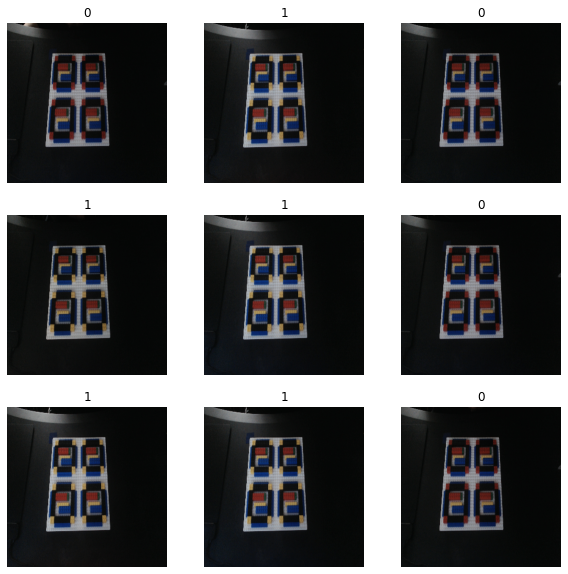

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i].numpy())])
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

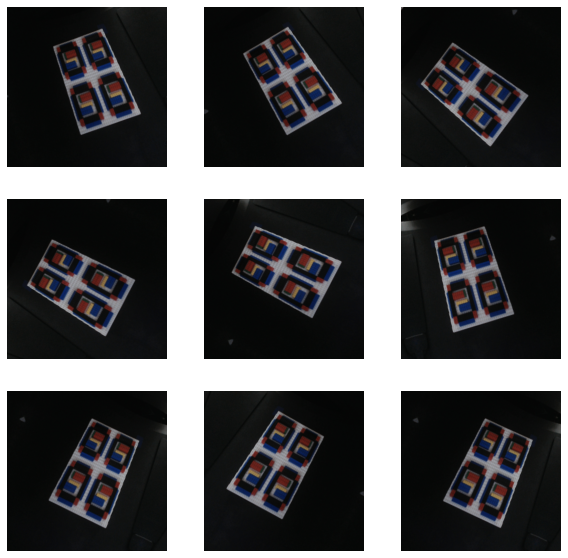

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [16]:
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = preprocess_input(x)

IMG_SHAPE = (299,299) + (3,)

base_model = InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

x = base_model(x)

model = tf.keras.Model(inputs=[i], outputs=[x])
# train_dataset = preprocess_input(train_dataset)
# val_dataset = preprocess_input(val_dataset)
# test_dataset = preprocess_input(test_dataset)

In [15]:
# IMG_SHAPE = (299,299) + (3,)

# base_model = InceptionV3(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=IMG_SHAPE,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax'
# )

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 1000)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 149, 149, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

ValueError: Input 0 of layer global_average_pooling2d_1 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (64, 1000)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

NameError: name 'feature_batch_average' is not defined